## Brachistochrone problem (static)

Adapted from https://scipython.com/blog/the-brachistochrone-problem/.

* v1: Last revised 13-Feb-2019 by Dick Furnstahl (furnstahl.1@osu.edu).


We assume that the curve starts at $(x_1, y_1) = (0, 0)$ and use the solution for the cycloid:

$\begin{align}
  x &= a (\theta - \sin\theta) \\
  y &= a (1 - \cos\theta) \;.
\end{align}$

We want to be solve the problem with a specified final point $(x_2, y_2)$, which means finding $a$ and $\theta_2$ (note that $\theta_1 = 0$).  We can find $\theta_2$ from the ratio:

$\begin{align}
  \frac{y_2}{x_2} = \frac{1 - \cos\theta_2}{\theta_2 - \sin\theta_2}  \,
\end{align}$

which we solve numerically by finding where the difference of the two sides is zero as a function of $\theta_2$.  We use the `scipy.integrate` function [`newton`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton), which implements the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method) for finding roots of an equation.

With $\theta_2$ known, $a$ is given by 

$\begin{align}
  a = \frac{y_2}{1 - \cos\theta_2} \;.
\end{align}$

For alternative paths, we consider a circle, a parabola, and a straight line.    The functional for the time to be minimized is:

$\begin{align}
  \mbox{time}(1\rightarrow 2)
   = \frac{1}{\sqrt{2g}} \int_{0}^{x_2} \frac{\sqrt{1 + y'(x)^2}}{\sqrt{y(x)}} dx 
  \;,
\end{align}$

which is written with $y(x)$ and $dx$ (i.e., an integral over $x$) rather than $x(y)$ and $dy$ as in Taylor.  (We still measure positive $y$ to be downward from the origin, in the same direction as gravity.)  

We evaluate the functional numerically in all cases, even when we could do it algebraically.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import newton
from scipy.integrate import quad

%matplotlib inline

In [13]:
def functional(x, f, df_dx):
    """The integrand of the time integral to be minimized for a path f(x)."""

    return np.sqrt((1. + df_dx(x)**2) / (2 * g * f(x)))


def cycloid(x_2, y_2, N=100):
    """Return the path of Brachistochrone curve from (0, 0) to (x_2, y_2).

    The Brachistochrone curve is the path down which a bead will slide without
    friction between two points in the least time (an arc of a cycloid).
    Returned as an array of N values of (x, y) between (0, 0) and (x_2, y_2).

    Solves for the value of theta_2 to correspond to (x_2, y_2), assuming
    it starts from the origin, from the given ratio of y_2/x_2, which should
    equal 
    """

    # First find theta_2 from (x_2, y_2) numerically (by Newton-Rapheson).
    def find_theta(theta):
        """Equation that will be zero for theta=theta_2 with 
            (x, y) = (x_2, y_2)."""
        return y_2/x_2 - (1. - np.cos(theta))/(theta - np.sin(theta))
    theta_2 = newton(find_theta, np.pi/2.)  # Second argument is first guess.

    # The radius of the circle generating the cycloid
    a = y_2 / (1. - np.cos(theta_2))

    # Set up array of x and y points from the origin to (x_2, y_2)
    theta_1 = 0.
    theta_pts = np.linspace(theta_1, theta_2, N)
    x_pts = a * (theta_pts - np.sin(theta_pts))
    y_pts = a * (1. - np.cos(theta_pts))

    # The time of travel
    T = theta_2 * np.sqrt(a / g)
    print(f'T(cycloid) = {T:.3f}')
    return x_pts, y_pts, T


def parabola(x_2, y_2, N=100):
    """Return the path of a parabolic arc between (0,0) to (x_2, y_2).

    The parabola used is the one with a vertical tangent at (0,0).

    """

    c = y_2**2/x_2

    def f_parabola(x):
        """Equation of a parabola going through the origin and (x_2, y_2)."""
        return np.sqrt(c*x)
    def df_parabola_dx(x):
        return c/2/f_parabola(x)

    x_pts = np.linspace(0, x_2, N)
    y_pts = f_parabola(x_pts)

    # Calculate the time of travel by numerical integration.
    T, T_error = quad(functional, 0., x_2, args=(f_parabola, df_parabola_dx))
    
    print(f'T(parabola) = {T:.3f}')
    return x_pts, y_pts, T


def circle(x_2, y_2, N=100):
    """Return the path of a circular arc between (0,0) to (x_2, y_2).

    The circle used is the one with a vertical tangent at (0,0).

    """

    # Circle radius
    r = x_2

    def f_circle(x):
        return np.sqrt(r**2-(x-r)**2)
    def df_circle_dx(x):
        return (r-x)/f_circle(x)

    x_pts = np.linspace(0, x_2, N)
    y_pts = f_circle(x_pts)

    # Calculate the time of travel by numerical integration.
    T, T_error = quad(functional, 0., x_2, args=(f_circle, df_circle_dx))
    print(f'T(circle) = {T:.3f}')
    return x_pts, y_pts, T


def linear(x_2, y_2, N=100):
    """Return the path of a straight line from (0,0) to (x_2, y_2)."""

    m = y_2/x_2


    def f_linear(x):
        return m*x
    def df_linear_dx(x):
        return m
    
    x_pts = np.linspace(0, x_2, N)
    y_pts = f_linear(x_pts)
    
    # Calculate time of travel
    T, T_error = quad(functional, 0., x_2, args=(f_linear, df_linear_dx))

    print(f'T(linear) = {T:.3f}')
    return x_pts, y_pts, T


T(cycloid) = 0.583
T(parabola) = 0.584
T(circle) = 0.592
T(linear) = 0.639


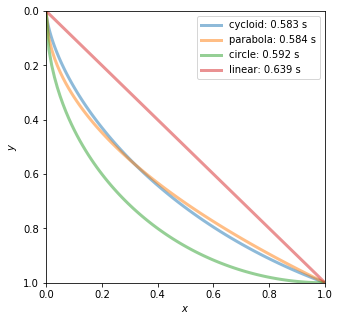

In [15]:
# Acceleration due to gravity (mks units); final position of bead (m).
g = 9.81
# Needs x_2 = y_2 for the circle plot
x_2, y_2 = 1., 1. #0.65

# Plot a figure comparing the four paths.
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

### for curve in ('cycloid', 'parabola', 'circle', 'linear'):
for curve in ('cycloid', 'parabola', 'circle', 'linear'):
    x, y, T = globals()[curve](x_2, y_2)
    ax.plot(x, y, lw=3, alpha=0.5, label=f'{curve}: {T:.3f} s')
ax.legend()

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(0, x_2)
ax.set_ylim(1, 0)
plt.savefig('PS6_2_plot.png')
plt.show()